In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import re
import pickle

In [48]:
clf = joblib.load("../training/rf.joblib")
clf

RandomForestClassifier(max_features=4)

In [49]:
df = pd.read_csv('../../data/dataset_from_json.csv')
df.head()

,words,sentence #,tag
0,CPT,0,Incoterms
1,LAHORE,0,Incoterms
2,AIRPORT,0,Incoterms
3,PAKISTAN,0,Incoterms
4,QTY,0,O


In [50]:
def remove_dot(x):
    pattern = '\w\.' # removes dots at the end of sentences... ex: "we went there." -> "we went there"
    finds = re.findall(pattern, x)
    for find in finds:
        x = re.sub(pattern, find[:-1], x)

    pattern_2 = '\.\w' # removes dots at the end of sentences. ex: "we went .there" -> "we went there"
    x = re.sub(pattern_2, '', x)

    pattern_3 = '\s\.\s' # removes dots at the end of sentences. ex: "abc . abc" -> "abc abc"
    x = re.sub(pattern_3, '', x)

    return x

In [51]:
# Save the embeddings
with open("../../models/embeddings/words_embeddings", "rb") as fp: 
    word2idx = pickle.load(fp)

# create more features
def feature_map(word):
    if word in word2idx.keys():
        return np.array([word2idx[word], word.isupper(), len(word), word.isdigit(), word.isalpha()])
    return np.array([word2idx['ENDPAD'], word.isupper(), len(word), word.isdigit(), word.isalpha()])

In [52]:
sentence = '00,000 Bottles ( +/- 05/05 %) of First Class Technical Machinery Soda, packed in blue crates labelled \'Test Machine London\' Unit Price: Usd 5,00 DELIVERY TERMS; CIF TORONTO HS    Code:    55678.334    '

sentence = sentence.replace('_x005F_x000D_','')
sentence = sentence.replace('\n',' ')
sentence = sentence.replace(':',' ')
sentence = sentence.replace('+)','')
sentence = re.sub('\d-', '', sentence)
sentence = re.sub('\(\d\)', '', sentence)
sentence = re.sub('\\d\)', '', sentence)
sentence = re.sub(',\s', '', sentence)
sentence = re.sub(',\w', '', sentence)
sentence = remove_dot(sentence)
sentence = sentence.replace(' - ','')
sentence = sentence.replace(',','')
sentence = sentence.replace('++++++++++++++++++++++++++++++++++++','')
sentence = sentence.strip()

words = sentence.split()
new_words = [feature_map(x) for x in words]


In [53]:
X = np.array(new_words)
X.shape

(30, 5)

In [54]:
for word, prediction in zip(words, clf.predict(X)):
    print(word, '--', prediction)

0000 -- Quantity
Bottles -- GoodsDescription
( -- O
+/- -- O
05/05 -- UnitPriceAmount
%) -- O
of -- O
First -- GoodsDescription
Class -- GoodsDescription
Technical -- O
Machinery -- O
Sodapacked -- O
in -- O
blue -- GoodsDescription
crates -- O
labelled -- GoodsDescription
'Test -- UnitPriceAmount
Machine -- GoodsDescription
London' -- UnitPriceAmount
Unit -- GoodsDescription
Price -- GoodsDescription
Usd -- O
50 -- Quantity
DELIVERY -- O
TERMS; -- O
CIF -- Incoterms
TORONTO -- GoodsDescription
HS -- O
Code -- GoodsDescription
55678334 -- O


In [55]:
len(words)

30

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0190096 to fit


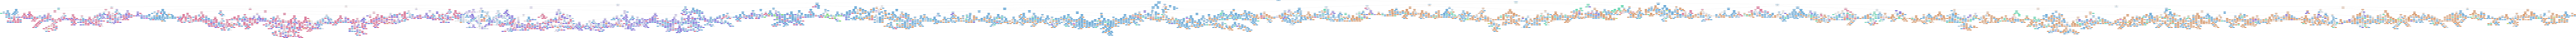

In [56]:
decision_tree = clf.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(decision_tree, out_file='tree.dot', 
                feature_names = ['word','isupper','length','isdigit','isalpha'],
                # class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = '../../utils/tree.png')